## Introduction

### Project background
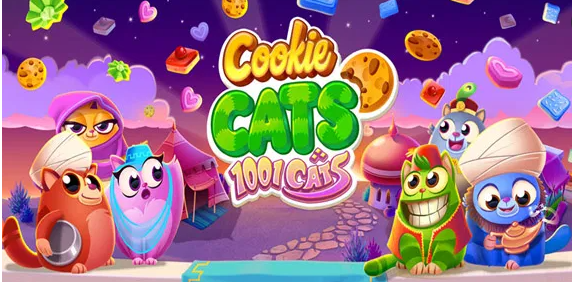

Cookie Cat is a popular mobile puzzle game where players complete a task and level up. While players completes levels, they encounter gates after completing certain number of levels. Gates force players to wait for sometime before they can play further or make in game purchases.

### Business problem
Even though Cookie Cats overall popularity is growing over time with players subcribing to try out the game, however,
1. Revenue from in-game purchases has been declining over time
2. Total number of active players are also declining with players uninstalling the game after playing for few days

### Project objective
Increase YoY revenue from game purchases by increasing retention rate of gamers.

### Hypothesis 
1. Company CEO believes that players are churning because the first gate encountered at level 30 is too early which forces players to wait before they can proceed further in the game
2. In order to increase player retention rate, developers ran AB-test by moving the first gate from level 30 to level 40 for some players 
    - Group A would encounter the gate at level 30
    - Group B would encounter the gate at level 40

### Analytic objective

Test CEO's hypothesis to analyze if moving the first game from level 30 to 40 increases retention rate and number of game rounds played.

### Metadata
Data provided for 90,189 players who installed the game while the AB-test was running. These are the variables and descriptions.

- userid: a unique number that identifies each player
- version: whether the player was put in the control group A (gate_30 - a gate at level 30) or the test group B (gate_40 - a gate at level 40)
- sum_gamerounds: the number of game rounds played by the player during the first week after installation
- retention_1: did the player come back and play 1 day after installing?
- retention_7: did the player come back and play 7 days after installing?

## 0.0 Packages and setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

from statsmodels.stats import weightstats as stests
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import mannwhitneyu

import scipy.stats as stats
import os
import pylab
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## 1.0 Reading data

In [4]:
#Read data using pandas
user_df = pd.read_csv("Mini_project_2_Data.csv")

#Check data types of each column using "dtypes" function
print("Data types for the data set:")
user_df.dtypes

#Check dimension of data i.e. # of rows and #column using pandas "shape" funtion
print("Shape of the data i.e. no. of rows and columns")
user_df.shape

#Display first 5 rows of the data using "head" function
print("First 5 rows of the raw data:")
user_df.head(5)

Data types for the data set:


userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Shape of the data i.e. no. of rows and columns


(90189, 5)

First 5 rows of the raw data:


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2.0 Data cleaning and initial processing

### Identify missing value

In [20]:
#Check for any missing values in the data using isnull() function
user_df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

<mark>__Results:__
    
    There is no missing value in the data. 

### Identify outliers

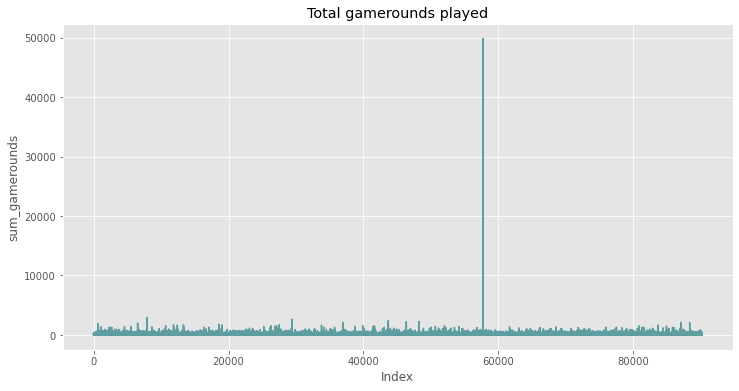

In [21]:
#Check for outlier values in sum_gamerounds column
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(user_df.sum_gamerounds,color = 'cadetblue')
plt.title("Total gamerounds played")
plt.xlabel("Index")
plt.ylabel("sum_gamerounds");

In [22]:
#Check basic stats of sum_gamerounds
user_df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [23]:
#Based on the plot, filter out the outlier from sum_gamerounds played; use max() fucntion to find the index of the outlier
user_df.sum_gamerounds.max()
user_df[user_df['sum_gamerounds'] > 10000]

49854

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


<mark>__Results:__
    
    The outlier number is 49854 and its index number is 57702.

In [5]:
#Remove the outlier
df2 = user_df.drop(57702) 

#Check dimension of data after removing the outlier
df2.shape

(90188, 5)

<mark>__Actions:__
    
    Outlier index has been dropped, 90188 rows remain as opposed to 90189 rows originally.

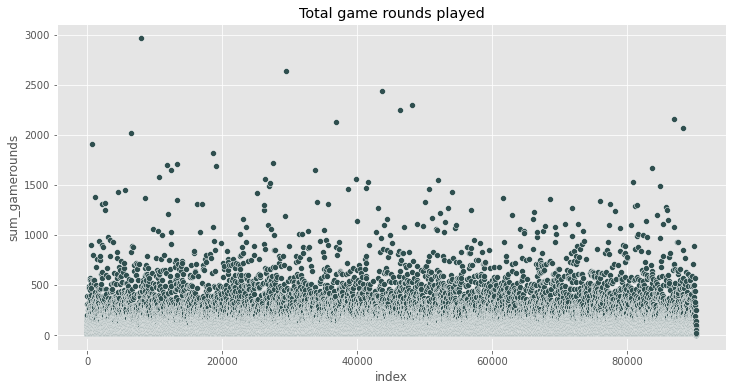

In [25]:
#Plot the graph for sum_gamerounds player after removing the outlier
fig = plt.gcf().set_size_inches(12, 6)
sns.scatterplot(data = df2.reset_index(), x = 'index', y = "sum_gamerounds", color = 'darkslategray')
plt.title("Total game rounds played");

## 3.0 Plot summary statistics and identify trends for basis business questions

### 3.1 Check overall 7-day retention rate of the game

In [6]:
#Calculation of 7-day retention rate
rr_7 = df2['retention_7'].sum() / df2['retention_7'].count()
rr_7 = '{:.1%}'.format(rr_7)
rr_7

'18.6%'

<mark>__Results:__
    
    Overall 7-day retention rate of the game for both versions is 18.6%.

### 3.2 Number of players never played the game after installing

In [27]:
#Find number of customers with sum_gamerounds is equal to zero
zero_game = (df2.sum_gamerounds == 0).sum()
zero_game

3994

<mark>__Results:__
    
    3994 users did not play a single game after installing.

### 3.3 Check number of users increase/decrease as the level progresses

In [28]:
#Define sum_gamerounds by quantile
q_high= df2['sum_gamerounds'].quantile(0.95)
q_high

q_low= df2['sum_gamerounds'].quantile(0.05)
q_low

221.0

1.0

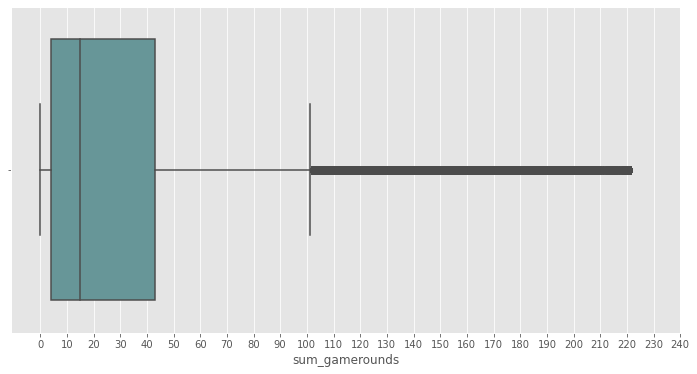

In [29]:
x = df2[df2['sum_gamerounds'] <= q_high]

fig, ax = plt.subplots(figsize = (12,6))
sns.boxplot(x['sum_gamerounds'], color = 'cadetblue');

major_ticks = np.arange(0, 250, 10) 
minor_ticks = np.arange(0, 250, 10) 

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True);

<mark>__Results:__
    
    Based on the boxplot for the first 95% of sum_gamerounds (sorted in ascending order), it shows the median for sum_gamerounds is 16 to 18 and that many players have reached more than 100 rounds.

In [30]:
#Group by sum_gamerounds and count the number of users for the first 200 gamerounds
f200 = df2.groupby('sum_gamerounds')['userid'].count()
f200[1:201].sum()

80972

<mark>__Results:__
    
    A total of 80972 users took part in the first 200 gamerounds excluding users played 0 game after installing.

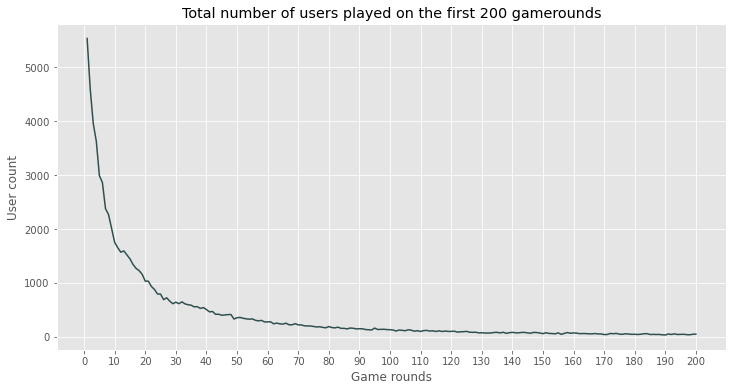

In [31]:
#Use plot() function on the summarized stats to visualize the chart
fig, ax = plt.subplots(figsize = (12,6))
f200[1:201].plot(x = "sum_gamerounds", y = "userid", color = 'darkslategray')
ax.set_title("Total number of users played on the first 200 gamerounds")
ax.set_xlabel("Game rounds")
ax.set_ylabel("User count");

major_ticks = np.arange(0, 201, 10) 
minor_ticks = np.arange(0, 201, 10) 

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True);

<mark>__Results:__
    
    There was a sharp decrease of users that stopped playing the game after first 20 game rounds.

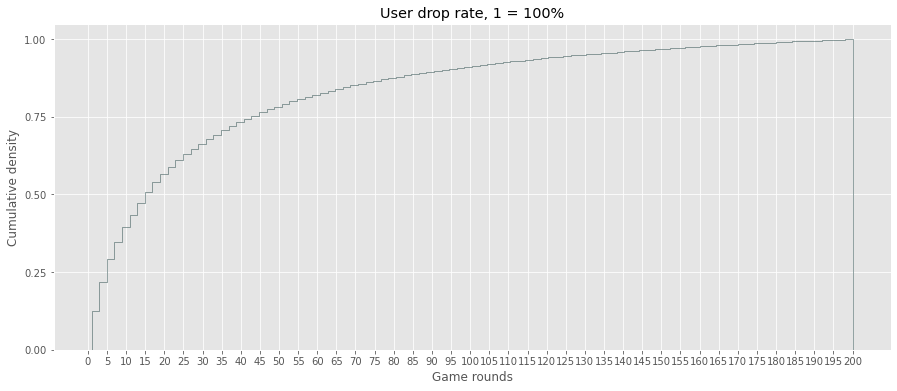

In [32]:
#Find drop rate for the first 200 gamerounds
first200 = df2.loc[(df2['sum_gamerounds'] > 0) & (df2['sum_gamerounds'] <= 200)]

fig, ax = plt.subplots(figsize = (15,6))
n_bins = 100
ax.hist(first200['sum_gamerounds'], n_bins, density = True, histtype = 'step', 
        cumulative = True, label = 'empirical',color = 'darkslategray')

ax.set_title("User drop rate, 1 = 100%")
ax.set_xlabel("Game rounds")
ax.set_ylabel("Cumulative density")

major_ticks = np.arange(0, 201, 5) 
ax.set_xticks(major_ticks)

major_ticks2 = np.arange(0, 1.05, 0.25) 
ax.set_yticks(major_ticks2);

<mark>__Analysis Results:__
    
    More than 25% of the users did not come back after the first 5 gamerounds. 
    About 50% of the users did not come back after the first 15 gamerounds.

In [33]:
#Check 0 sum_gamerounds retention status 
zerogame_both = df2.loc[(df2['sum_gamerounds'] == 0) & (df2['retention_1'] == True) & (df2['retention_7'] == True)]
zerogame_both.head(5)

zerogame_day1 = df2.loc[(df2['sum_gamerounds'] == 0) & (df2['retention_1'] == True)]
zerogame_day1.head(5)

zerogame_day7 = df2.loc[(df2['sum_gamerounds'] == 0) & (df2['retention_7'] == True)]
zerogame_day7.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
2803,307703,gate_40,0,True,True
25595,2849235,gate_40,0,True,True
32780,3641794,gate_30,0,True,True
42976,4752783,gate_40,0,True,True
62945,6975780,gate_40,0,True,True


,userid,version,sum_gamerounds,retention_1,retention_7
1872,203165,gate_30,0,True,False
2330,257330,gate_30,0,True,False
2803,307703,gate_40,0,True,True
3994,442819,gate_30,0,True,False
4239,471012,gate_30,0,True,False


,userid,version,sum_gamerounds,retention_1,retention_7
1000,110479,gate_30,0,False,True
2803,307703,gate_40,0,True,True
6923,767142,gate_30,0,False,True
11895,1313585,gate_40,0,False,True
15894,1764023,gate_30,0,False,True


<mark>__Results: Additional information__
    
Some of the retention rate appears dubious when results reflect "True" on day 1 or day 7 or both from 0 sum_gamerounds.

## 4.0 Generate crosstab for two groups of players to understand if there is a difference in 7 days retention rate & total number of game rounds played

### 4.1 Seven days retention rate summary for different game versions

In [38]:
#Create cross tab for game version and retention_7 flag counting number of users for each possible categories
pd.crosstab(df2.version, df2.retention_1)
pd.crosstab(df2.version, df2.retention_1).apply(lambda r: r / r.sum(), axis = 1)

pd.crosstab(df2.version, df2.retention_7)
pd.crosstab(df2.version, df2.retention_7).apply(lambda r: r / r.sum(), axis = 1)

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


retention_1,False,True
version,,
gate_30,0.551802,0.448198
gate_40,0.557717,0.442283


retention_7,False,True
version,,
gate_30,36198,8501
gate_40,37210,8279


retention_7,False,True
version,,
gate_30,0.809817,0.190183
gate_40,0.818000,0.182000


<mark>__Analsysis Results:__
    
Both versions appear similar outcomes, with more than 50% or 24000 of players stopped playing on day 1; retention rates below 20% or less than 8500 users, and high churn rates around 80% or more than 36000 users on day 7.

### 4.2 Gamerounds summary for different game versions

In [29]:
#Use pandas groupby to calculate average game rounds played summarized by different versions
df2.groupby(["version"]).sum_gamerounds.agg(["median"])
df2.groupby(["version"]).sum_gamerounds.agg(["mean"])

,median
version,
gate_30,17
gate_40,16


,mean
version,
gate_30,51.342111
gate_40,51.298776


<mark>__Analsysis Results:__

There is no difference in the total number of gamerounds played by each player based on different versions of the game.\
Half of players played no more than 17 rounds and 75% of players played no more than average mean 51 rounds based on analysis results in section 3.3.

### 4.3 Average gamerounds in seven days retention rate for different game versions

In [32]:
df2[(df2.retention_1 == True) & (df2.version == "gate_30")].sum_gamerounds.mean()
df2[(df2.retention_1 == True) & (df2.version == "gate_40")].sum_gamerounds.mean()

94.41170010981332

95.3811819672946

In [30]:
df2[(df2.retention_7 == True) & (df2.version == "gate_30")].sum_gamerounds.mean()
df2[(df2.retention_7 == True) & (df2.version == "gate_40")].sum_gamerounds.mean()

165.6498369368281

160.1175155864016

<mark>__Analsysis Results:__
    
Both versions appear similar outcomes on day 1 and day 7.

## 5.0 Perform two-sample test for groups A and B to test statistical significance amongst the groups in the sum of game rounds played i.e., if groups A and B are statistically different

### 5.1 Initial data processing for hypothesis testing

In [33]:
#Define A/B groups for hypothesis testing
group_A = pd.DataFrame(df2[df2.version == "gate_30"]['sum_gamerounds'])
group_B = pd.DataFrame(df2[df2.version == "gate_40"]['sum_gamerounds'])

### 5.2 Shapiro test of Normality

In [62]:
#---------------------- Shapiro Test ----------------------
# NULL Hypothesis H0: Distribution is normal
# ALTERNATE Hypothesis H1: Distribution is not normal    

print('Test for group_A')

stat,p = shapiro(group_A)
print('The test-statistic and p-value are as follows:\nTest-statistic = %.3f , p-value = %.3f'%(stat,p))
if p > 0.05:
    print (p,' > 0.05, hence null hypothesis is failed to reject and distribution is normal.')
else:
    print (p,' < 0.05, hence reject null hypothesis, and the distribution is not normal.')

print('\n')

print('Test for group_B')

stat,p = shapiro(group_B)
print('The test-statistic and p-value are as follows:\nTest-statistic = %.3f , p-value = %.3f'%(stat,p))
if p > 0.05:
    print (p,' > 0.05, hence null hypothesis is failed to reject and distribution is normal.')
else:
    print (p,' < 0.05, hence reject null hypothesis, and the distribution is not normal.')

Test for group_A
The test-statistic and p-value are as follows:
Test-statistic = 0.489 , p-value = 0.000
0.0  < 0.05, hence reject null hypothesis, and the distribution is not normal.


Test for group_B
The test-statistic and p-value are as follows:
Test-statistic = 0.483 , p-value = 0.000
0.0  < 0.05, hence reject null hypothesis, and the distribution is not normal.


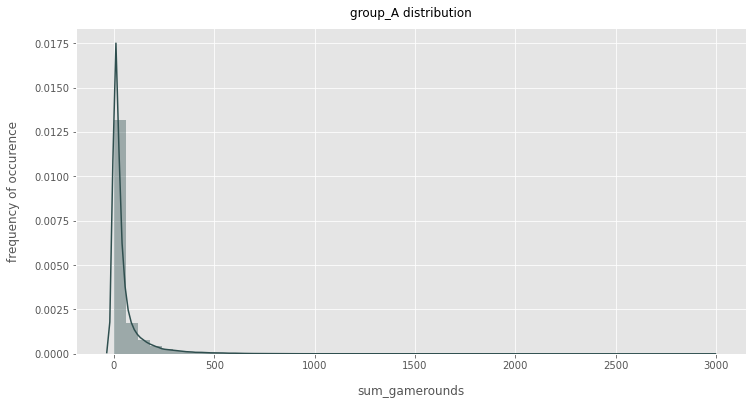

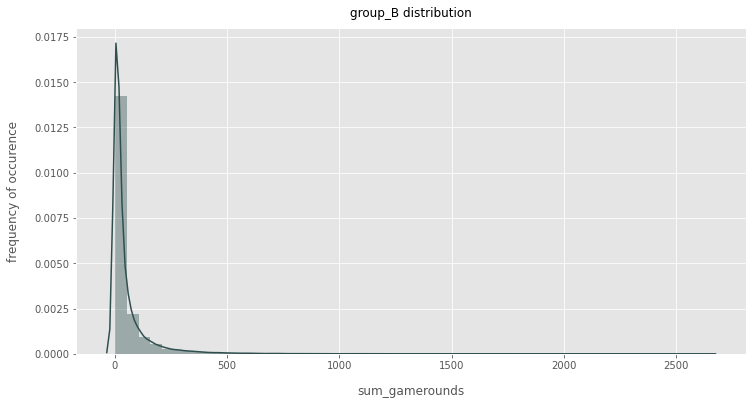

In [63]:
fig, ax = plt.subplots(figsize = (12,6))    
sns.distplot(group_A, color = 'darkslategray')
plt.title("group_A distribution", y = 1.015, fontsize = 12)
plt.xlabel("sum_gamerounds", labelpad = 14)
plt.ylabel("frequency of occurence", labelpad = 14);
        
fig, ax = plt.subplots(figsize = (12,6))    
sns.distplot(group_B, color = 'darkslategray')
plt.title("group_B distribution", y = 1.015, fontsize = 12)
plt.xlabel("sum_gamerounds", labelpad = 14)
plt.ylabel("frequency of occurence", labelpad = 14);

<mark>__Analsysis Results:__
    
The result from shapiro test of normality for two sample groups appear similar distribution.\
Both samples are skewed towards the right and not normally distributed.
    Group A has longer tail than group B which may implies more rounds played by users at testing level gate-30.

### 5.3 Test of homegienity of variance

In [35]:
#---------------------- Leven's Test ----------------------
# NULL Hypothesis H0: Two groups have equal variances
# ALTERNATE Hypothesis H1: Two groups do not have equal variances

#perform levene's test and accept or reject the null hypothesis based on the results

stat, p = levene(group_A['sum_gamerounds'], group_B['sum_gamerounds'])
print('The test-statistic and p-value are as follows:\nTest-statistic = %.3f , p-value = %.3f'%(stat,p))
if p > 0.05:
    print (p,' > 0.05, hence fail to reject null hypothesis and the two groups have equal variances.')
else:
    print (p,' < 0.05, hence reject null hypothesis, and the two groups do not have equal variances.')

The test-statistic and p-value are as follows:
Test-statistic = 0.075 , p-value = 0.784
0.7840494387892463  > 0.05, hence fail to reject null hypothesis and the two groups have equal variances.


<mark>__Analsysis Results:__
    
The result of Levene test reflects both group A and B have equal variance.\
We can take the assumption that on average, the values they can take, are spread out equally from their respective means.

### 5.4 Test of significance: Two sample test

In [64]:
#---------------------- Two samples test ----------------------
# NULL Hypothesis H0: Two samples are equal
# ALTERNATE Hypothesis H1: Two samples are different

#Apply relevant two sample test to accept or reject the NULL hypothesis

#Using Mann-Whitney U test (for non-parametric, non-normal distribution, dependant variables, independant variables, 
#independant observations)

stat, p = mannwhitneyu(group_A, group_B)
print('The test-statistic and p-value are as follows:\n U-value = %.3f , p-value = %.3f'%(stat,p))
if p > 0.05:
    print(p,' > 0.05, hence fail to reject null hypothesis and the two samples are equal')
else:
    print(p,' < 0.05, hence reject null hypothesis, and the two samples are different')

The test-statistic and p-value are as follows:
 U-value = 1009027049.500 , p-value = 0.025
0.02544577639572688  < 0.05, hence reject null hypothesis, and the two samples are different


In [65]:
#Test with alternative greater
stat, p = mannwhitneyu(group_A, group_B, alternative = 'greater')
print('The test-statistic and p-value are as follows:\n U-value = %.3f , p-value = %.3f'%(stat,p))
if p > 0.05:
    print(p,' > 0.05, hence fail to reject null hypothesis and the two samples are equal')
else:
    print(p,' < 0.05, hence reject null hypothesis, and the two samples are different')

The test-statistic and p-value are as follows:
 U-value = 1024285761.500 , p-value = 0.025
0.02544577639572688  < 0.05, hence reject null hypothesis, and the two samples are different


<mark>__Analsysis Results:__
    
As a result from first test, the two sample groups are statistically different of the median that are caused by the independent variable. Another test is conducted with alternate hypothesis and the result is that group A stochastically dominates group B when group A has higher number of times observations (U-value) in the ranking.  

## 6.0 Identify which level has more advantage in terms of player retention and number of game rounds played

In [53]:
#Analyze the 1 day and 7 days retention rate for two different groups using group by function
df2[['version','retention_1','retention_7','sum_gamerounds']].groupby('version').agg('mean')

,retention_1,retention_7,sum_gamerounds
version,,,
gate_30,0.448198,0.190183,51.342111
gate_40,0.442283,0.182000,51.298776


### Findings
Based on our results, version gate 30 has a slightly higher percentage retention rate on day 1 and day 7 compared to version gate 40. Therefore, the company __should not__ increase the first gate to Level 40 when raising the level to gate 40 makes no difference in retention rate. 

### Recommendation
The company should come up with a way to keep their player base. There's a possibility that the game is too difficult to play when 25% of users left after the first 5 rounds, half of users after the first 15 rounds (median = 17 gamerounds) based on the finding in first 200 game rounds.

In a psychological way of thinking, another hypothesis which accounts for the slight higher retention rate on gate 30 is, it is the nearer achievement level, which encourages a player to play more and stay longer.

To retain users from the beginning, the company should review the difficulty of the starting levels of games and user demographics. Moreover, the company could offer rewards and challenges to entice users to stay on the game.

## 7.0 Using bootstrap resampling to plot the retention rate distribution for both the groups in order to visualize effect of different version of the game on retention.

In [46]:
#Plot density function

In [66]:
#bootstrap function
def bootstrap_rep(data, func):
    bs_sample = np.random.choice(data,len(data))
    return func(bs_sample)

def bs_reps(data, func, size = 1):
    bs_rep = np.empty(size)
    for i in range(size):
        bs_rep[i] = bootstrap_rep(data, func)
        
    return bs_rep

__Retention rate day 1__ 

In [55]:
gate_30_ren_1 = df2[df2['version'] == 'gate_30']['retention_1']
gate_40_ren_1 = df2[df2['version'] == 'gate_40']['retention_1']

In [72]:
#get boostrap replicates of mean
bs_rep_30 = bs_reps(gate_30_ren_1,np.mean,1000)
bs_rep_40 = bs_reps(gate_40_ren_1,np.mean,1000)

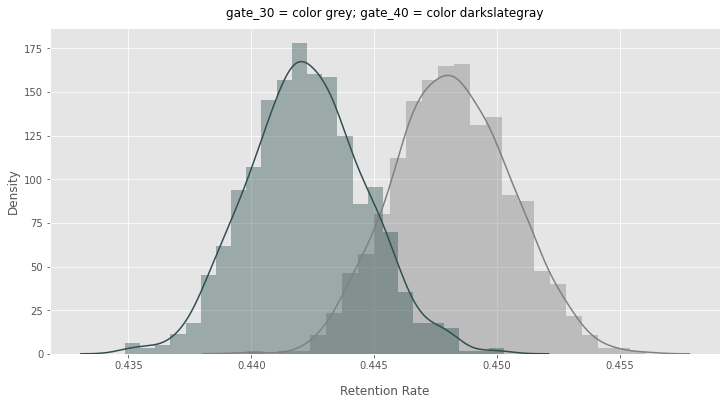

In [73]:
fig, ax = plt.subplots(figsize = (12,6))
boot_1d = pd.DataFrame(bs_rep_30)
sns.distplot(boot_1d, color = 'grey')

boot_1d = pd.DataFrame(bs_rep_40)
sns.distplot(boot_1d, color = 'darkslategray')

plt.title("gate_30 = color grey; gate_40 = color darkslategray", y = 1.015, fontsize = 12)
plt.xlabel("Retention Rate", labelpad = 14);

__Retention rate day 7__

In [58]:
gate_30_ren_7 = df2[df2['version'] == 'gate_30']['retention_7']
gate_40_ren_7 = df2[df2['version'] == 'gate_40']['retention_7']

In [59]:
#get boostrap replicates of mean
bs_rep_30_7 = bs_reps(gate_30_ren_7,np.mean,1000)
bs_rep_40_7 = bs_reps(gate_40_ren_7,np.mean,1000)

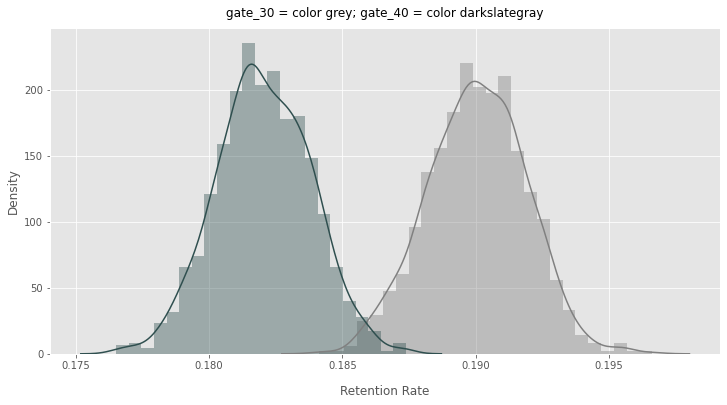

In [60]:
fig, ax = plt.subplots(figsize = (12,6))
boot_7d = pd.DataFrame(bs_rep_30_7)
sns.distplot(boot_7d, color = 'grey')

boot_7d = pd.DataFrame(bs_rep_40_7)
sns.distplot(boot_7d, color = 'darkslategray')

plt.title("gate_30 = color grey; gate_40 = color darkslategray", y = 1.015, fontsize = 12)
plt.xlabel("Retention Rate", labelpad = 14);

<mark>__Analsysis Results:__
    
The above plots are visual representations of the difference in retention rate between the two versions of the group, and they are consistent with previous analysis suggesting that the gate30 version of the game has a higher retention rate. Retention1 has some overlap, but retention7 has little and suggests that the retention distributions are different.